In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import random 

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.images = self.load_images()

    def load_images(self):
        images = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                images.append((img_path, self.class_to_idx[cls_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
input_dir = '../input'
path_to_train = os.path.join(input_dir, 'asl-alphabet', 'asl_alphabet_train', 'asl_alphabet_train')
path_to_test = os.path.join(input_dir, 'asl-alphabet-test', 'asl-alphabet-test')

In [2]:
####### attempt with CustomDataset #######

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=5),  
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.02), 
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(path_to_train, transform=train_transforms)

test_dataset = CustomDataset(path_to_test, transform=transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [3]:

alexnet_model = models.alexnet(pretrained=True)


num_classes = len(train_dataset.classes)
alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=0.0001)

C:\Users\txchf\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\txchf\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:

# num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
alexnet_model.to(device)
# for epoch in range(num_epochs):
num_iters = 2000
iter_counter = 0
iter = [0]
test_accuracy = [0]
train_accuracy = [0]
epoch_counter = 0
while iter_counter < num_iters:
    alexnet_model.train()
    running_loss = 0.0
    total_samples = 0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        if iter_counter >= num_iters:
            break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = alexnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
        
        #### Cathy added #####
        _, predicted_train = torch.max(outputs, 1)
        correct_train += (predicted_train == labels).sum().item()
        total_train += labels.size(0)
        ######################

        iter_counter += 1
        
        if ((iter_counter+1) % 50 == 0):
            train_acc = correct_train / total_train * 100
            train_accuracy.append(train_acc)
            
            print(f"Iteration {iter_counter+1}/{num_iters}, Training Loss: {running_loss/total_samples:.4f}, Training Accuracy: {correct_train / total_train * 100:.2f}%")
            running_loss = 0.0
      
            alexnet_model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = alexnet_model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            

            print(f"Iteration {iter_counter+1}/{num_iters}, Testing Accuracy: {(correct/total)*100:.2f}%")
            iter.append(iter_counter+1)
            test_accuracy.append((correct/total)*100)
            running_loss = 0.0
            total_samples = 0
            alexnet_model.train()

torch.save(alexnet_model.state_dict(), 'fine_tuned_alexnet.pth')

using cuda
Iteration 50/2000, Training Loss: 2.4126, Training Accuracy: 32.02%
Iteration 50/2000, Testing Accuracy: 26.78%
Iteration 100/2000, Training Loss: 0.7334, Training Accuracy: 54.67%
Iteration 100/2000, Testing Accuracy: 36.21%
Iteration 150/2000, Training Loss: 0.4407, Training Accuracy: 65.10%
Iteration 150/2000, Testing Accuracy: 45.40%
Iteration 200/2000, Training Loss: 0.2797, Training Accuracy: 71.31%
Iteration 200/2000, Testing Accuracy: 40.80%
Iteration 250/2000, Training Loss: 0.2380, Training Accuracy: 75.59%
Iteration 250/2000, Testing Accuracy: 47.01%
Iteration 300/2000, Training Loss: 0.1750, Training Accuracy: 78.68%
Iteration 300/2000, Testing Accuracy: 47.36%
Iteration 350/2000, Training Loss: 0.1730, Training Accuracy: 80.97%
Iteration 350/2000, Testing Accuracy: 45.52%
Iteration 400/2000, Training Loss: 0.1236, Training Accuracy: 82.93%
Iteration 400/2000, Testing Accuracy: 47.59%
Iteration 450/2000, Training Loss: 0.1243, Training Accuracy: 84.31%
Iteration 

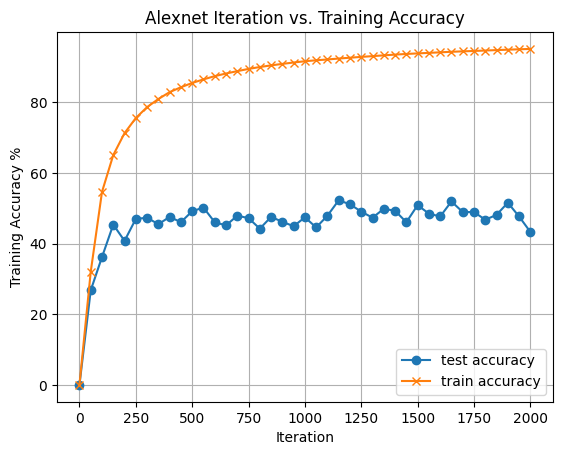

In [5]:
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy %")
plt.title("Alexnet Iteration vs. Training Accuracy")
plt.plot(iter, test_accuracy, marker='o')
plt.plot(iter, train_accuracy, marker='x')
plt.legend(['test accuracy', 'train accuracy']) 
plt.grid()

plt.savefig("withaug.png")
plt.show()

In [6]:
len(test_accuracy), len(train_accuracy)

(41, 41)

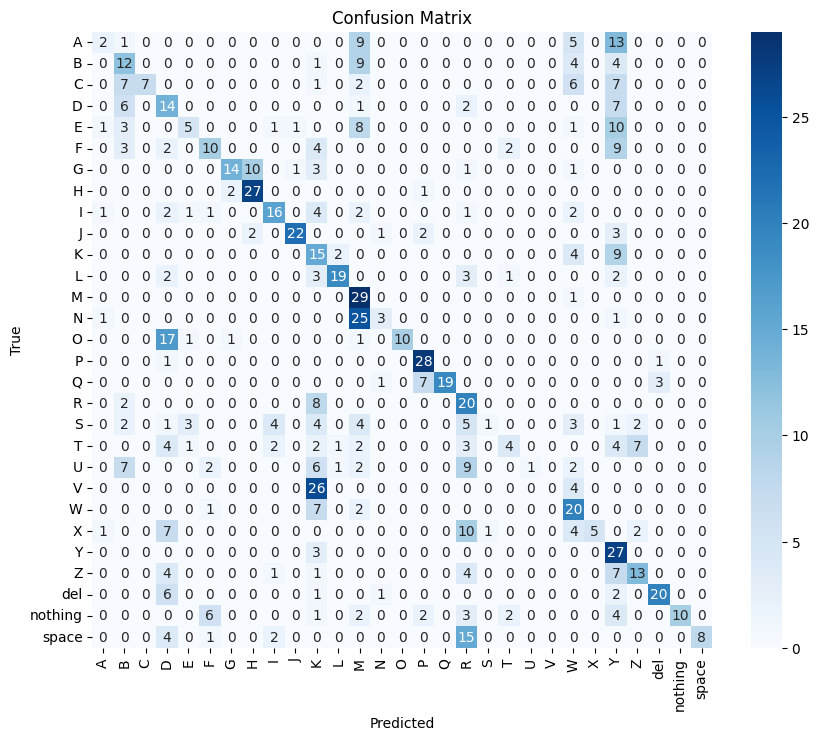

In [9]:
alexnet_model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = alexnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy()) 
        true_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model.load_state_dict(torch.load('fine_tuned_alexnet.pth',map_location=device))
alexnet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

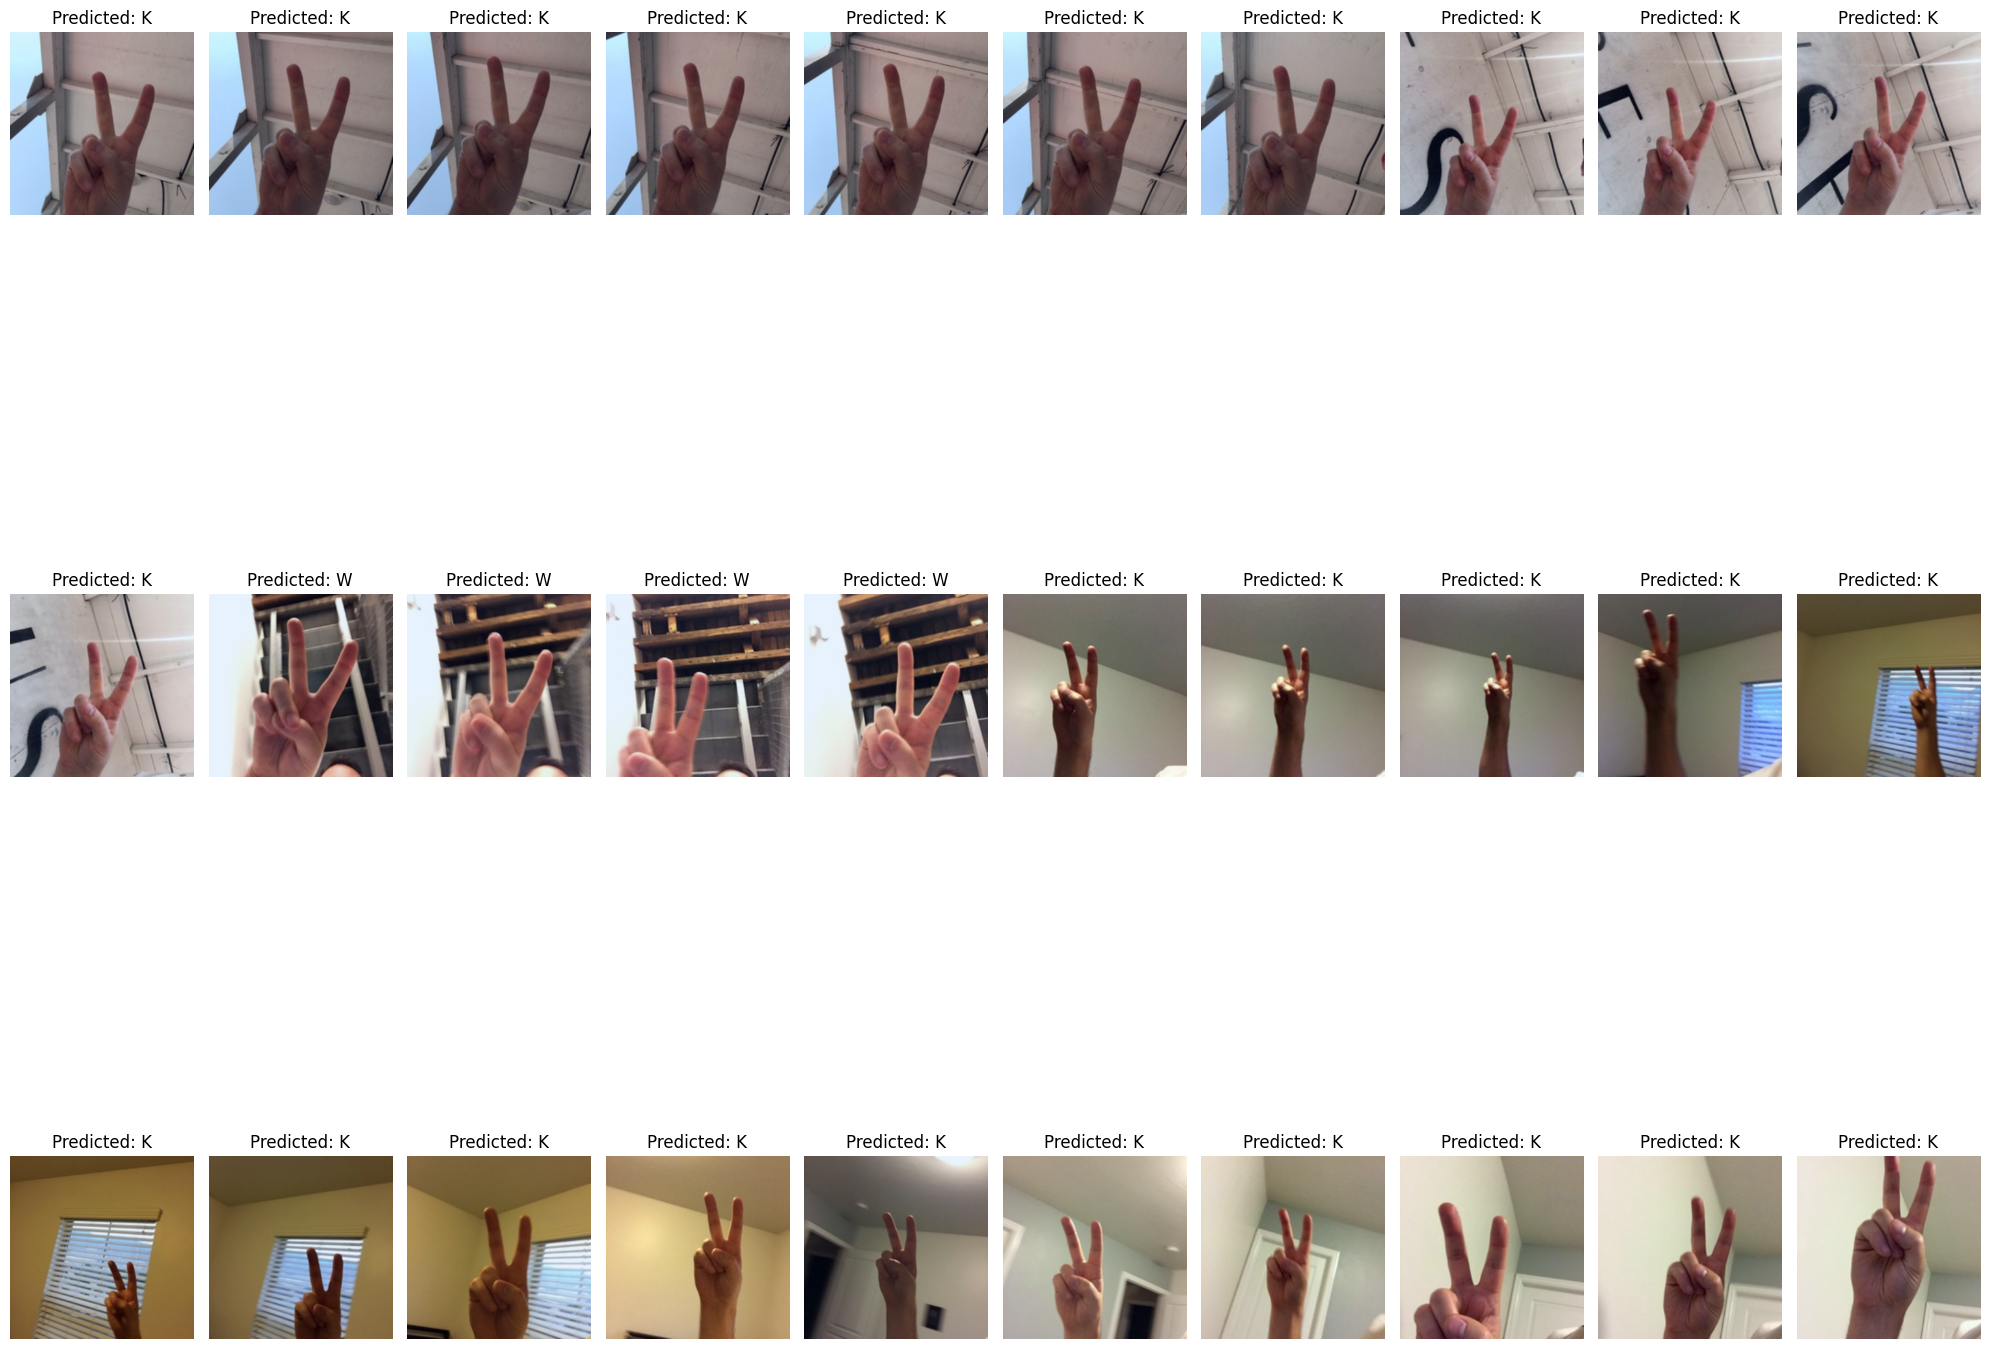

In [5]:
alexnet_model.eval()

v_images = []
v_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = alexnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        v_images.extend(inputs[labels == test_dataset.classes.index("V")].cpu().numpy())
        v_labels.extend(predicted[labels == test_dataset.classes.index("V")].cpu().numpy())

fig, axes = plt.subplots(3, 10, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    img = np.transpose(v_images[i], (1, 2, 0))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    ax.imshow(img)
    ax.set_title(f"Predicted: {test_dataset.classes[v_labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

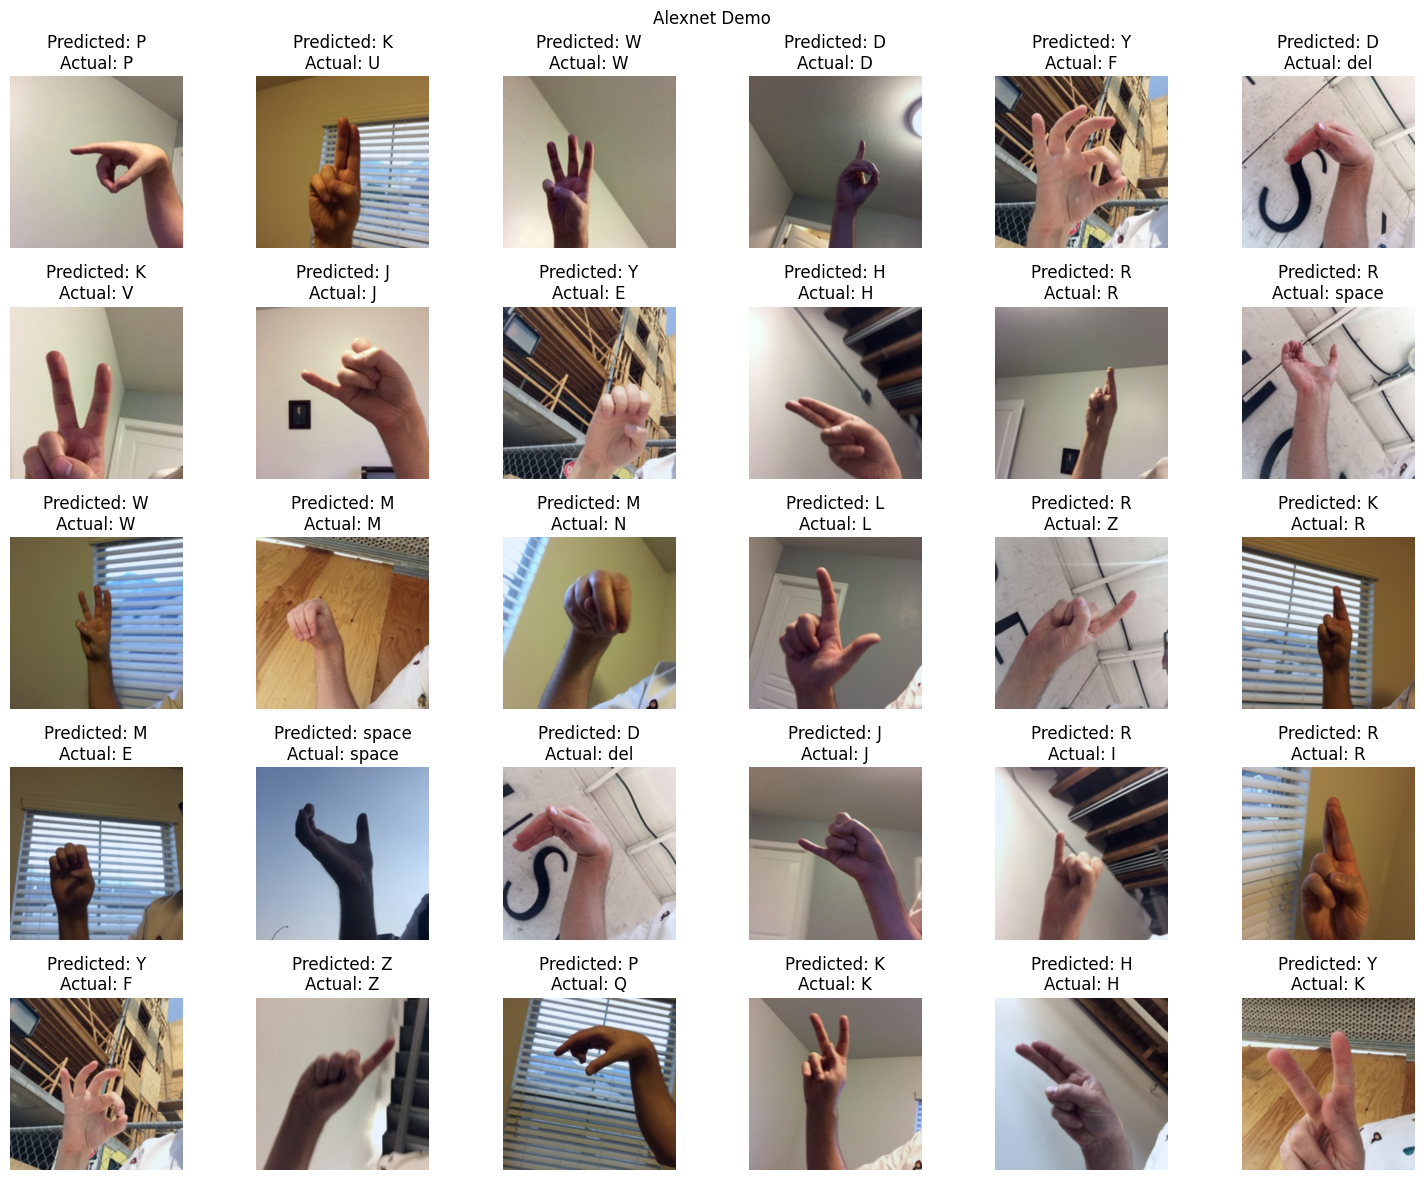

In [6]:
alexnet_model.eval()
random_indices = random.sample(range(len(test_dataset)), 30)
sampled_images = []
predicted_labels = []
actual_labels = []

with torch.no_grad():
    for i in random_indices:
        input, label = test_dataset[i]
        input = input.to(device).unsqueeze(0)         
        output = alexnet_model(input)
        _, predicted = torch.max(output, 1)
        sampled_images.append(input.cpu().squeeze(0))  
        predicted_labels.append(predicted.item())
        actual_labels.append(label)

fig, axes = plt.subplots(5, 6, figsize=(15, 12))  
axes = axes.ravel()

for i, ax in enumerate(axes):
    img = np.transpose(sampled_images[i].cpu().numpy(), (1, 2, 0))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    ax.imshow(img)
    ax.set_title(f'Predicted: {test_dataset.classes[predicted_labels[i]]}\nActual: {test_dataset.classes[actual_labels[i]]}')
    ax.axis('off')

fig.suptitle("Alexnet Demo")
plt.tight_layout()
plt.show()